# Minneapolis Purple Air Sensor Project
## Elevation data wrangling ETL and QAQC

In [1]:
import arcpy # use arc pro objects and functions
import shutil # For deleting folders
from arcpy import env # to set working environmnet
import pandas as pd # manipulate data
import requests #fetch data from apis
import zipfile #compressed data
import io #data decoding
import numpy as np #make arrays out of rasters
import psycopg2 # manage sql and db connection
import os # file managment
from arcpy.ia import * # for merging rasters

### Set up environment

In [2]:
# Get CWD

cwd = _dh[0] #this is a universal variable that calls the directory where the .ipynb file is located

# Create GeoDataBase

# arcpy.management.CreateFileGDB(os.path.join(cwd, '..', '..', 'data'), 'QAQC.gdb') # This is the communal GeoDataBase

# Make it workspace

arcpy.env.workspace = os.path.join(cwd, '..', '..', 'data', 'QAQC.gdb')

#set project directory path
#proj_dir = os.path.join(cwd, '..', '..', 'data')

#set geodatabase path
#proj_gdb = r'C:\Users\MrJDF\Desktop\arc2_lab2\mpls_prplair_qaqc\mpls_prplair_qaqc.gdb'
# set project aprx file path
#aprx = arcpy.mp.ArcGISProject(r'C:\Users\MrJDF\Desktop\arc2_lab2\mpls_prplair_qaqc\mpls_prplair_qaqc.aprx')
#set arcpy environment, this is where this code will store the imported data
#arcpy.env.workspace = proj_dir

# allow files to be overwritten
arcpy.env.overwriteOutput = True 
#test
arcpy.env.workspace

'D:\\QualityAirQualityCities\\arcpy\\qaqc\\..\\..\\data\\QAQC.gdb'

###  define functions

In [3]:
# set up fnction to unzip requests and save to the project's working directory
def unzip(input_zipped, out_filepath):
    get_zipped = zipfile.ZipFile(
        io.BytesIO(
            input_zipped.content)
    )
    
    get_zipped.extractall(out_filepath)

In [4]:
# function to verify srs

def verify_srs(raster_in, expected_srs_name, expected_type):
    desc = arcpy.Describe(raster_in)
    srs = desc.spatialReference
    if srs.name == expected_srs_name and srs.type == expected_type:
        print('SRS OK', '\n', 'srs:', srs.name, '\n', 'type:', srs.type)

    else:
        print('ERROR: spatial reference system incompatible')

### buffer definition

In [5]:
#buffer

# Specify the input feature class path and name
input_fc = 'mpls_boundary'
# Specify the output feature class path and name for the buffer
output_buffer = 'mpls_2km_buffer'

# Buffer the input feature class to 2km
arcpy.Buffer_analysis(input_fc, output_buffer, "2000 Meters")

<Result 'D:\\QualityAirQualityCities\\arcpy\\qaqc\\..\\..\\data\\QAQC.gdb\\mpls_2km_buffer'>

### Get the data

In [6]:
# set data url endpoint
base = r'https://resources.gisdata.mn.gov/pub/data/elevation/lidar/projects/metro/block_metro/geodatabase/'
# test set
# gdb_list = [r'3542-31-22.gdb.zip',
#             r'3542-31-23.gdb.zip',
# ]
# Uncomment the following list to process the entire aoi, data transfer will take time approx 15 min, uses 12 gb of storage
gdb_list = [r'3542-31-22.gdb.zip',
            r'3542-31-23.gdb.zip',
            r'3542-31-24.gdb.zip',
            r'3542-31-25.gdb.zip',
            r'3542-31-26.gdb.zip',
            r'3542-31-27.gdb.zip',
            r'3542-32-22.gdb.zip',
            r'3542-32-23.gdb.zip',
            r'3542-32-24.gdb.zip',
            r'3542-32-25.gdb.zip',
            r'3542-32-26.gdb.zip',
            r'3542-32-27.gdb.zip',
            r'4342-01-22.gdb.zip',
            r'4342-01-23.gdb.zip',
            r'4342-01-24.gdb.zip',
            r'4342-01-25.gdb.zip',
            r'4342-01-26.gdb.zip',
            r'4342-01-27.gdb.zip',
            r'4342-02-22.gdb.zip',
            r'4342-02-23.gdb.zip',
            r'4342-02-24.gdb.zip',
            r'4342-02-25.gdb.zip',
            r'4342-02-26.gdb.zip',
            r'4342-02-27.gdb.zip',
            r'4342-03-22.gdb.zip',
            r'4342-03-23.gdb.zip',
            r'4342-03-24.gdb.zip',
            r'4342-03-25.gdb.zip',
            r'4342-03-26.gdb.zip',
            r'4342-03-27.gdb.zip',
            r'4342-04-22.gdb.zip',
            r'4342-04-23.gdb.zip',
            r'4342-04-24.gdb.zip',
            r'4342-04-25.gdb.zip',
            r'4342-04-26.gdb.zip',
            r'4342-04-27.gdb.zip',
            r'4342-05-22.gdb.zip',
            r'4342-05-23.gdb.zip',
            r'4342-05-24.gdb.zip',
            r'4342-05-25.gdb.zip',
            r'4342-05-26.gdb.zip',
            r'4342-05-27.gdb.zip',
           ]

In [65]:
# fetch the data & clip

# estimated completion time 20 minutes, 
# Will take up ~ 13 gb of local storage - see commented code at end of loop if you don't have this much space!

# set save filepath
savepath = os.path.join(cwd, '..','..','data')
clipped_rast_names = []

for i, gdb in enumerate(gdb_list):
    
    # has the file been downloaded/unzipped
    
    if not os.path.exists(os.path.join(savepath, gdb[:-4])):
        
        ## If not Fetch
        
        response = requests.get(base + gdb)
        unzip(response, savepath)

    rastname = gdb.replace(".zip", "") + "\dem_1m_m"

    ## Clip

    # Set the input and output file paths
    input_raster = os.path.join(savepath, rastname)
    output_raster = f'temp_{i}'
    
    clipped_rast_names.append(output_raster)

    #set extent
    clipping_extent = output_buffer

    # Clip the input raster to the clipping extent
    arcpy.Clip_management(input_raster, clipping_extent, output_raster, "#", "#", "NONE")
    
    
#     # Uncomment if you want to delete raw data as it's processed <- haven't tested but I think it works
    
#     shutil.rmtree(os.path.join(savepath, gdb[:-4]))

In [66]:
## Merge - Takes another 5-10 minutes

rast_name_raw = os.path.join(savepath, 'aoi_elev_raw.tif')

aoi_elev = arcpy.ia.Merge(clipped_rast_names, "First") # Use the first pixel value if overlap

aoi_elev.save(rast_name_raw)

In [88]:
# Delete tempororary files

# arcpy.ListRasters()

for rast_name in clipped_rast_names:
    arcpy.management.Delete(rast_name) # Remove the temporary raster

## Quality Checks

In [68]:
# create a raster object from the output to use as the main input variable for qaqc
dem = arcpy.Raster(rast_name_raw)

### Visual Check for Logical Consistency, Completeness

In [69]:
#TODO: add the clipped raster to the map

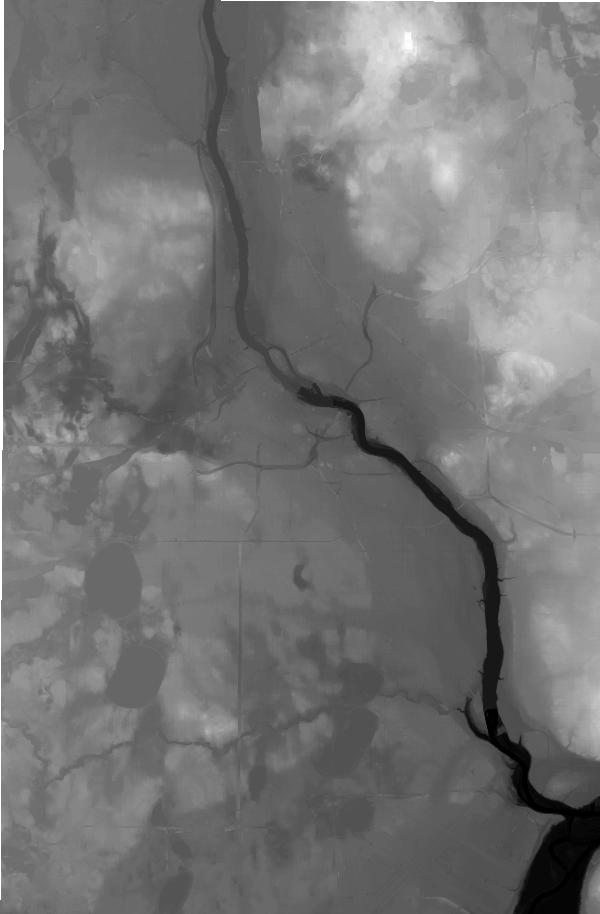

In [70]:
# display the raster in notebook

inRaster = rast_name_raw

rendered_raster = arcpy.Render(inRaster, 
                               rendering_rule= {'bands': 1},
                               colormap ='gray')
rendered_raster

### Review File Attributes
- compatability and use

In [71]:
# Create a Describe object from the raster dataset to get object charatersitics
desc = arcpy.Describe(inRaster)

# Print some raster dataset properties
print("Band Count:       %d" % desc.bandCount)
print("Compression Type: %s" % desc.compressionType)
print("Raster Format:    %s" % desc.format)
#print("Permanent:        %s" % desc.permanent)
#print("Sensor Type:      %s" % desc.sensorType)

Band Count:       1
Compression Type: None
Raster Format:    TIFF


### Input Spatial Reference System Check

In [72]:
# Is the SRS correct and is it a projected type srs to ensure compatability with transformation to epsg 4326 for web maps

verify_srs(dem, 'NAD_1983_UTM_Zone_15N', 'Projected')

SRS OK 
 srs: NAD_1983_UTM_Zone_15N 
 type: Projected


### No Data Check

In [73]:
# Check for any nodata values in the DEM

if arcpy.management.GetRasterProperties(inRaster, "ANYNODATA"):
    print("Nodata values found in DEM") # This is expected
else:
    print("No nodata values found in DEM")

Nodata values found in DEM


In [81]:
# make sure null value is set

#set file path for output
out_dem_null = 'aoi_elev'

# set the no data value to -3.4028231e+38
no_data_value = -3.4028231e+38

# use the SetNull function to convert the no data values to null values
out_raster = arcpy.sa.SetNull(arcpy.sa.Raster(dem) == no_data_value, dem)

# save the output raster to disk
out_raster.save(out_dem_null)

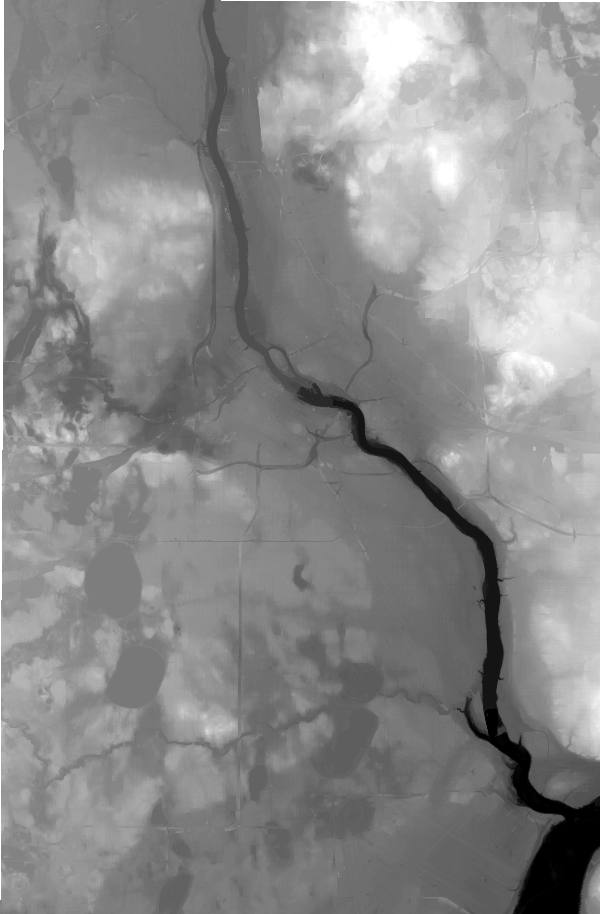

In [82]:
arcpy.Raster(out_dem_null)

### Threshold Range Check
- is the data within a reasonale range for elevation in minnesota?

In [83]:
# Set the path to the raster dataset
raster_path = out_dem_null

# Set the threshold values in meters
minimum_threshold = 200
maximum_threshold = 330

# Use the GetRasterProperties_management function to get the minimum and maximum values
desc = arcpy.GetRasterProperties_management(raster_path, "MINIMUM")
minimum_value = float(desc.getOutput(0))

desc = arcpy.GetRasterProperties_management(raster_path, "MAXIMUM")
maximum_value = float(desc.getOutput(0))

print('min value = ', minimum_value, '\n', 'max val = ', maximum_value)

#Check if the minimum and maximum values are within the threshold range
if minimum_value > minimum_threshold and maximum_value <= maximum_threshold:
    print("Minimum and maximum values are within the threshold range.")
else:
    print("WARNING: Minimum and maximum values are outside the threshold range.")

min value =  209.374206542969 
 max val =  329.877685546875
Minimum and maximum values are within the threshold range.


## Downsample Raster For Database Compatability
- the dem created above is approxamately 2.5 GB
- Here wee will downsample by a factor of 100 to save space and increase efficiency
- This is for the lab02 requirements only

- we should eventually only upload a small buffer around each sensor location for QAQC elevaton check puroposes in our official workflow

In [84]:
# Set the input raster file path
input_raster = out_dem_null

# Set the output raster file path
output_raster = "aoi_elev_downsmpl"

# Get the cell size of the input raster
desc = arcpy.Describe(input_raster)
cell_size = desc.meanCellWidth # or desc.meanCellHeight, depending on your analysis

# Set an appropriate cell size for the output raster
output_cell_size = cell_size * 100 # increase the cell size by a factor of 100

# Resample the input raster using bilinear interpolation
arcpy.Resample_management(input_raster, output_raster, output_cell_size, "BILINEAR")

<Result 'D:\\QualityAirQualityCities\\arcpy\\qaqc\\..\\..\\data\\QAQC.gdb\\aoi_elev_downsmpl'>

### Transform raster srs from NAD_1983 sql friendly format (epsg 4326) WGS_84

In [85]:
#transform raster srs from NAD_1983 sql friendly format (epsg 4326) WGS_84

# set the output raster variable and the new spatial reference using a WKID
out_dem_4326 = os.path.join(savepath, "aoi_elev_4326_downsmpl.tif")
new_srs = arcpy.SpatialReference(4326)  # WKID for WGS 84

# use the ProjectRaster_management function to project the raster
arcpy.ProjectRaster_management("aoi_elev_downsmpl", out_dem_4326, new_srs)

<Result 'D:\\QualityAirQualityCities\\arcpy\\qaqc\\..\\..\\data\\aoi_elev_4326_downsmpl.tif'>

### Output Spatial Reference System Check

In [86]:
# Check the results

verify_srs(out_dem_4326, 'GCS_WGS_1984', 'Geographic')

SRS OK 
 srs: GCS_WGS_1984 
 type: Geographic


# Convert DEM Raster to Points


In [93]:
# For Local GeoDataBase

# Convert raster to point feature class
arcpy.RasterToPoint_conversion("aoi_elev_downsmpl", 'elevation_points')

# For database

# Set the path to the raster dataset
raster_path = os.path.join(savepath, "aoi_elev_4326_downsmpl.tif")
# Set the input and output paths
input_raster = raster_path
output_point = os.path.join(savepath, "aoi_elev_4326_points.shp")

# Convert raster to point feature class
arcpy.RasterToPoint_conversion(input_raster, output_point)

<Result 'D:\\QualityAirQualityCities\\arcpy\\qaqc\\..\\..\\data\\aoi_elev_4326_points.shp'>

### Upload Points Table to remote DB

In [8]:
# Get credentials

cred_pth = os.path.join(os.getcwd(), '..', '..', 'database', 'db_credentials.txt')

with open(cred_pth, 'r') as f:
    
    creds = f.readlines()[0].split(', ')

# Connect to PostGIS Database

pg_connection_dict = dict(zip(['dbname', 'user', 'password', 'port', 'host'], creds))

conn = psycopg2.connect(**pg_connection_dict)

<connection object at 0x0000020CB69C6590; dsn: 'user=postgres password=xxx dbname=lab0 host=34.123.228.238 port=5432', closed: 0>

In [12]:
points = os.path.join(savepath, "aoi_elev_4326_points.shp")
fields_points = ['pointid', 'grid_code', "Shape@WKT"]

# Create SQL table
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS elevation_points")
cursor.execute("""
    CREATE TABLE elevation_points (
        id SERIAL,
        pointid INT,
        grid_code INT)
""")

cursor.execute("""
    SELECT AddGeometryColumn('elevation_points', 'geom', 4326, 'POINT', 2)
""")

# Populate PostGIS
with arcpy.da.SearchCursor(points, fields_points) as da_cursor:
    for row in da_cursor:
        wkt = row[2]
        cursor.execute("INSERT INTO elevation_points (pointid, grid_code, geom) VALUES (%s, %s, ST_GeomFromText(%s, 4326))", (row[0], row[1], wkt))

conn.commit()

## Create SQL tables in remote DB from raster data

- Use the Subprocess Library to run the raster to sql function in the notebook

In [30]:
# import os
# import subprocess
# import sys

# # Set the input raster file path and output PostGIS raster table name
# input_raster = os.path.join(savepath, "aoi_elev_4326_downsmpl.tif")
# raster_table = "minneapolisDEM"

# # Set the PostGIS connection parameters
# postgis_host = creds[4]
# postgis_port = creds[3]
# postgis_user = creds[1]
# postgis_password = creds[2]
# postgis_db = creds[0]

# # Set the SRID for the raster data
# #srid = "4326"
# srid = "4269"

# # Set the PATH environment variable for the subprocess
# postgis_bin_path = r"C:\Program Files\PostgreSQL\15\bin"  # Replace <version> with your PostgreSQL version
# os.environ["PATH"] = postgis_bin_path + os.pathsep + os.environ["PATH"]

# # Set the PGPASSWORD environment variable for the raster2pgsql command
# os.environ["PGPASSWORD"] = postgis_password

# # Build the raster2pgsql command with the tiling option
# raster2pgsql_cmd = f"raster2pgsql -s {srid} -I -C -M -t 128x128 {input_raster} -F {raster_table} | psql -h {postgis_host} -p {postgis_port} -U {postgis_user} -d {postgis_db}"

# # Execute the raster2pgsql command
# process = subprocess.run(raster2pgsql_cmd, shell=True, stderr=subprocess.PIPE, text=True)
# if process.returncode != 0:
#     print("An error occurred while running the raster2pgsql command:")
#     print(process.stderr)
#     sys.exit(1)

# print("Raster data successfully imported to PostGIS.")

Raster data successfully imported to PostGIS.
